# Gradient boosting tuning

Будем работать с данными - http://datahack.analyticsvidhya.com/contest/data-hackathon-3x.
Мы решаем задачу классификации на два класса. Сразу будем работать с обработанными и уменьшенными данными (для ускорения процесса обучения). Процесс обработки данных и полный и подробный туториал для данной задачи приведён здесь: https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_GBM_with_Example/GBM%20model.ipynb

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Загружаем данные

Вы можете работать с train_medium/test_medium, если готовы немного подождать при обучении xgboost. Если вы хотите быстрых результатов, то работайте с файлами train_small/test_small.

In [2]:
X_train = pd.read_csv('train_medium.csv')
X_test = pd.read_csv('test_medium.csv')
len(X_train), len(X_test)

(65265, 21755)

In [3]:
target='Disbursed'
IDcol = 'ID'

In [4]:
X_train['Disbursed'].value_counts(), len(X_train)

(0.0    64316
 1.0      949
 Name: Disbursed, dtype: int64, 65265)

## Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенный в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [5]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Начинаем последовательный подбор параметров при большом learning_rate


Model Report
Accuracy : 0.9858
AUC Score (Train): 0.869911
CV Score : Mean - 0.8297655 | Std - 0.01232237 | Min - 0.8167797 | Max - 0.8505192


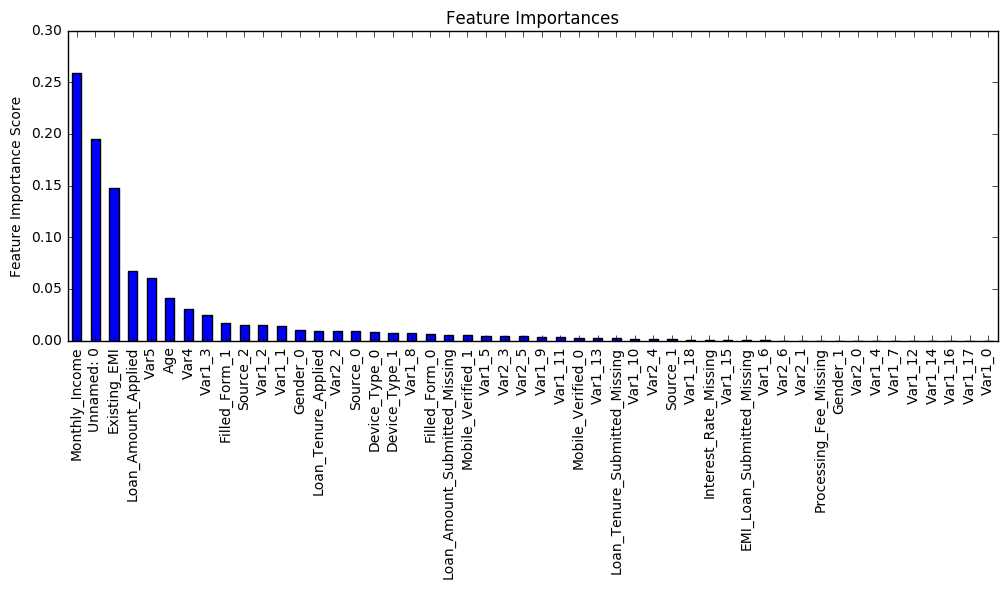

In [6]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [7]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train[predictors],X_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [8]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.82983, std: 0.01062, params: {'n_estimators': 20},
  mean: 0.83293, std: 0.00897, params: {'n_estimators': 30},
  mean: 0.83423, std: 0.00864, params: {'n_estimators': 40},
  mean: 0.83463, std: 0.00880, params: {'n_estimators': 50},
  mean: 0.83455, std: 0.00894, params: {'n_estimators': 60},
  mean: 0.83406, std: 0.00956, params: {'n_estimators': 70},
  mean: 0.83391, std: 0.00927, params: {'n_estimators': 80}],
 {'n_estimators': 50},
 0.8346282027725728)

Уточняем предсказание

In [9]:
param_test2 = {'max_depth':range(5,16,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train[predictors],X_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [10]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83193, std: 0.01126, params: {'max_depth': 5},
  mean: 0.83092, std: 0.01043, params: {'max_depth': 7},
  mean: 0.81905, std: 0.00788, params: {'max_depth': 9},
  mean: 0.80525, std: 0.01429, params: {'max_depth': 11},
  mean: 0.79304, std: 0.01205, params: {'max_depth': 13},
  mean: 0.78933, std: 0.01296, params: {'max_depth': 15}],
 {'max_depth': 5},
 0.8319263468470943)

Зафиксируем найденный max_depth и подберем min_samples_split

In [12]:
param_test2b = {'min_samples_split':range(200,1001,200)}
gsearch2b = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50,max_depth=5,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train[predictors],X_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [13]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.83244, std: 0.00982, params: {'min_samples_split': 200},
  mean: 0.83252, std: 0.00948, params: {'min_samples_split': 400},
  mean: 0.83276, std: 0.00962, params: {'min_samples_split': 600},
  mean: 0.83170, std: 0.00921, params: {'min_samples_split': 800},
  mean: 0.83141, std: 0.00980, params: {'min_samples_split': 1000}],
 {'min_samples_split': 600},
 0.8327596027467894)

Мы подобрали max_depth и min_samples_split - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр max_features.

In [ ]:
param_test3 = {'max_features':range(7,20,2)}

#Your code here

In [ ]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Установите в качестве параметров алгоритма подобранные max_depth, min_samples_split и max_features и посмотрите как изменилось качество.

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150,max_depth=..., min_samples_split=..., 
                                         random_state=10, max_features=...)
modelfit(gbm_tuned_1, X_train, X_test, predictors)

Подберите по сетке параметр subsample. Используйте значения этого параметра: [0.6,0.7,0.8,0.9,1.]

In [ ]:
#Your code here

Подберите параметр min_samples_leaf. Попробуйте range(30,71,10)

In [ ]:
#Your code here

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150,max_depth=..., min_samples_split=..., 
                                         random_state=10, max_features=...,
                                         subsample=..., min_samples_leaf=...)
modelfit(gbm_tuned_1, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [ ]:
#Your code here